In [ ]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Dataset preparation

In [ ]:
original_df = pd.read_csv('./mixed_candump-2024-05-28_121103.csv')
df = original_df.sample(frac=0.05) # pegando 5% dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33215 entries, 302937 to 96558
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label                  33215 non-null  object 
 1   id                     33215 non-null  int64  
 2   byte0                  33215 non-null  int64  
 3   byte1                  33215 non-null  int64  
 4   byte2                  33215 non-null  int64  
 5   byte3                  33215 non-null  int64  
 6   byte4                  33215 non-null  int64  
 7   byte5                  33215 non-null  int64  
 8   byte6                  33215 non-null  int64  
 9   byte7                  33215 non-null  int64  
 10  time_interval          33215 non-null  float64
 11  same_id_time_interval  33215 non-null  float64
dtypes: float64(2), int64(9), object(1)
memory usage: 3.3+ MB


In [ ]:
sns.set_theme()

In [ ]:
df.head(10)

,label,id,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,time_interval,same_id_time_interval
404455,MALIGN,0,0,0,0,0,0,0,0,0,0.000413,0.000413
488064,BENIGN,2021,2,1,246,85,85,85,85,85,0.000226,0.026431
73785,MALIGN,0,0,0,0,0,0,0,0,0,0.000402,0.000402
156734,MALIGN,0,0,0,0,0,0,0,0,0,0.000412,0.000412
426484,MALIGN,2018,0,65,13,0,0,0,0,0,0.000799,0.000799
90421,MALIGN,0,0,0,0,0,0,0,0,0,0.000391,0.000391
78835,MALIGN,0,0,0,0,0,0,0,0,0,0.000424,0.000424
231016,MALIGN,0,0,0,0,0,0,0,0,0,0.000447,0.000447
163036,MALIGN,0,0,0,0,0,0,0,0,0,0.000415,0.000415
79753,MALIGN,0,0,0,0,0,0,0,0,0,0.000448,0.000448


## Visual analysis on key columns

MALIGN count: 525617, BENIGN count: 138685


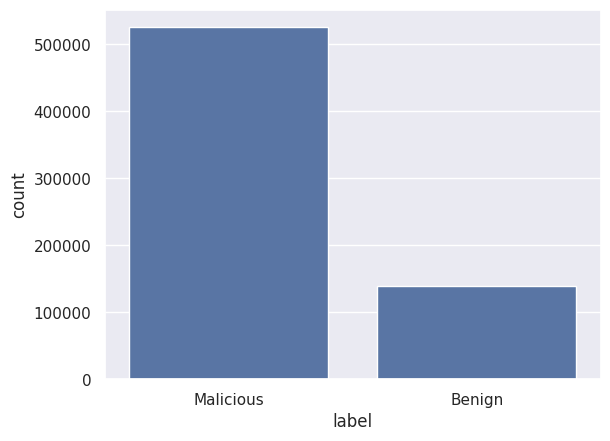

In [ ]:
# @title distribuição de dados benignos/malignos
sns.countplot(data=df['label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='label')
print(f"MALIGN count: {len(df[df.label == 'MALIGN'])}, BENIGN count: {len(df[df.label == 'BENIGN'])}")

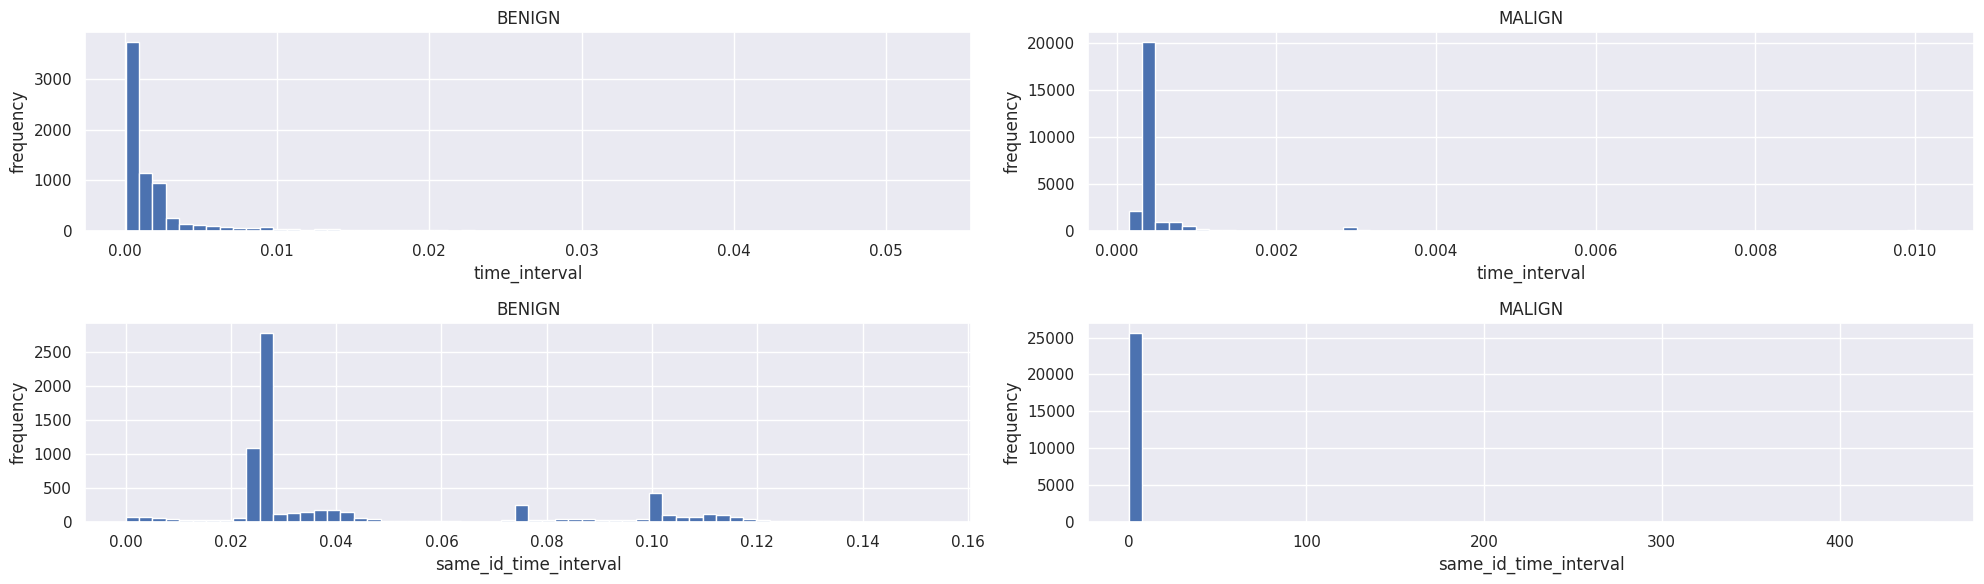

In [ ]:
# @title Histograma de time_interval e same_id_time_interval
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
df[df.label == 'BENIGN']['time_interval'].plot(kind='hist', bins=60)
plt.xlabel('time_interval')
plt.ylabel('frequency')
plt.title("BENIGN")
plt.subplot(2, 2, 2)
df[df.label == 'MALIGN']['time_interval'].plot(kind='hist', bins=60)
plt.xlabel('time_interval')
plt.ylabel('frequency')
plt.title("MALIGN")
plt.subplot(2, 2, 3)
df[df.label == 'BENIGN']['same_id_time_interval'].plot(kind='hist', bins=60)
plt.xlabel('same_id_time_interval')
plt.ylabel('frequency')
plt.title("BENIGN")
plt.subplot(2, 2, 4)
df[df.label == 'MALIGN']['same_id_time_interval'].plot(kind='hist', bins=60)
plt.xlabel('same_id_time_interval')
plt.ylabel('frequency')
plt.title("MALIGN")
plt.tight_layout()


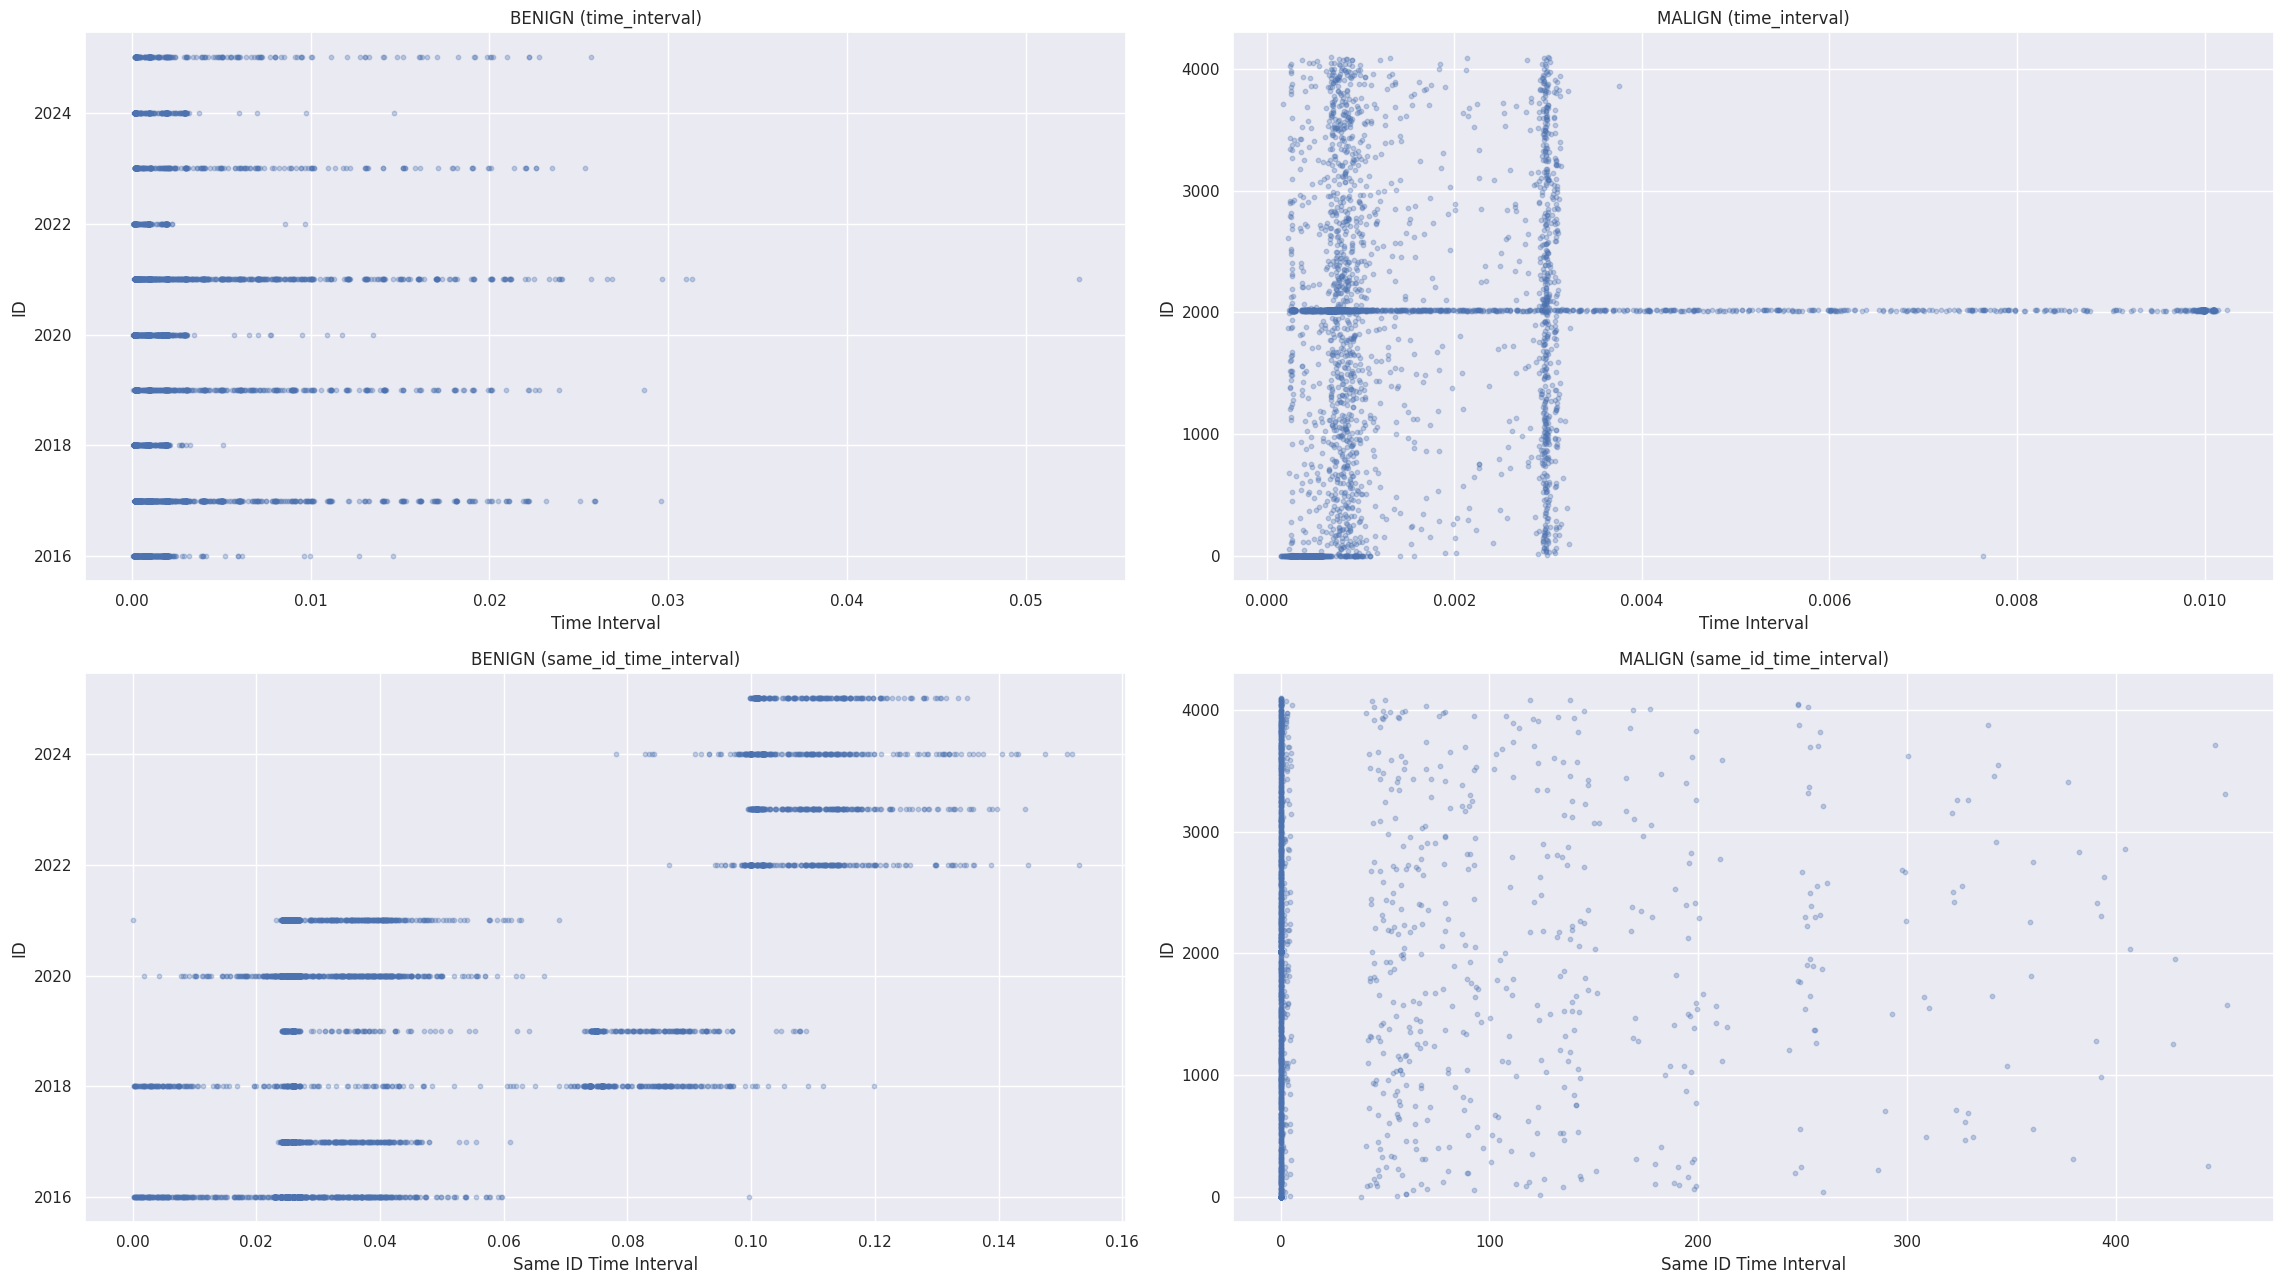

In [ ]:
# @title distribuição de id X time_interval e id X same_id_time_interval por tipo

fig, ((ax1_0, ax1_1), (ax2_0, ax2_1)) = plt.subplots(2, 2, figsize=(23, 13))

# Plot for BENIGN label with time_interval
ax1_0.scatter(df[df['label'] == 'BENIGN']['time_interval'], df[df['label'] == 'BENIGN']['id'], s=10, alpha=0.3)
ax1_0.set_title('BENIGN (time_interval)')
ax1_0.set_xlabel('Time Interval')
ax1_0.set_ylabel('ID')

# Plot for MALIGN label with time_interval
ax1_1.scatter(df[df['label'] == 'MALIGN']['time_interval'], df[df['label'] == 'MALIGN']['id'], s=10, alpha=0.3)
ax1_1.set_title('MALIGN (time_interval)')
ax1_1.set_xlabel('Time Interval')
ax1_1.set_ylabel('ID')

# Plot for BENIGN label with same_id_time_interval
ax2_0.scatter(df[df['label'] == 'BENIGN']['same_id_time_interval'], df[df['label'] == 'BENIGN']['id'], s=10, alpha=0.3)
ax2_0.set_title('BENIGN (same_id_time_interval)')
ax2_0.set_xlabel('Same ID Time Interval')
ax2_0.set_ylabel('ID')

# Plot for MALIGN label with same_id_time_interval
ax2_1.scatter(df[df['label'] == 'MALIGN']['same_id_time_interval'], df[df['label'] == 'MALIGN']['id'], s=10, alpha=0.3)
ax2_1.set_title('MALIGN (same_id_time_interval)')
ax2_1.set_xlabel('Same ID Time Interval')
ax2_1.set_ylabel('ID')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'ID')

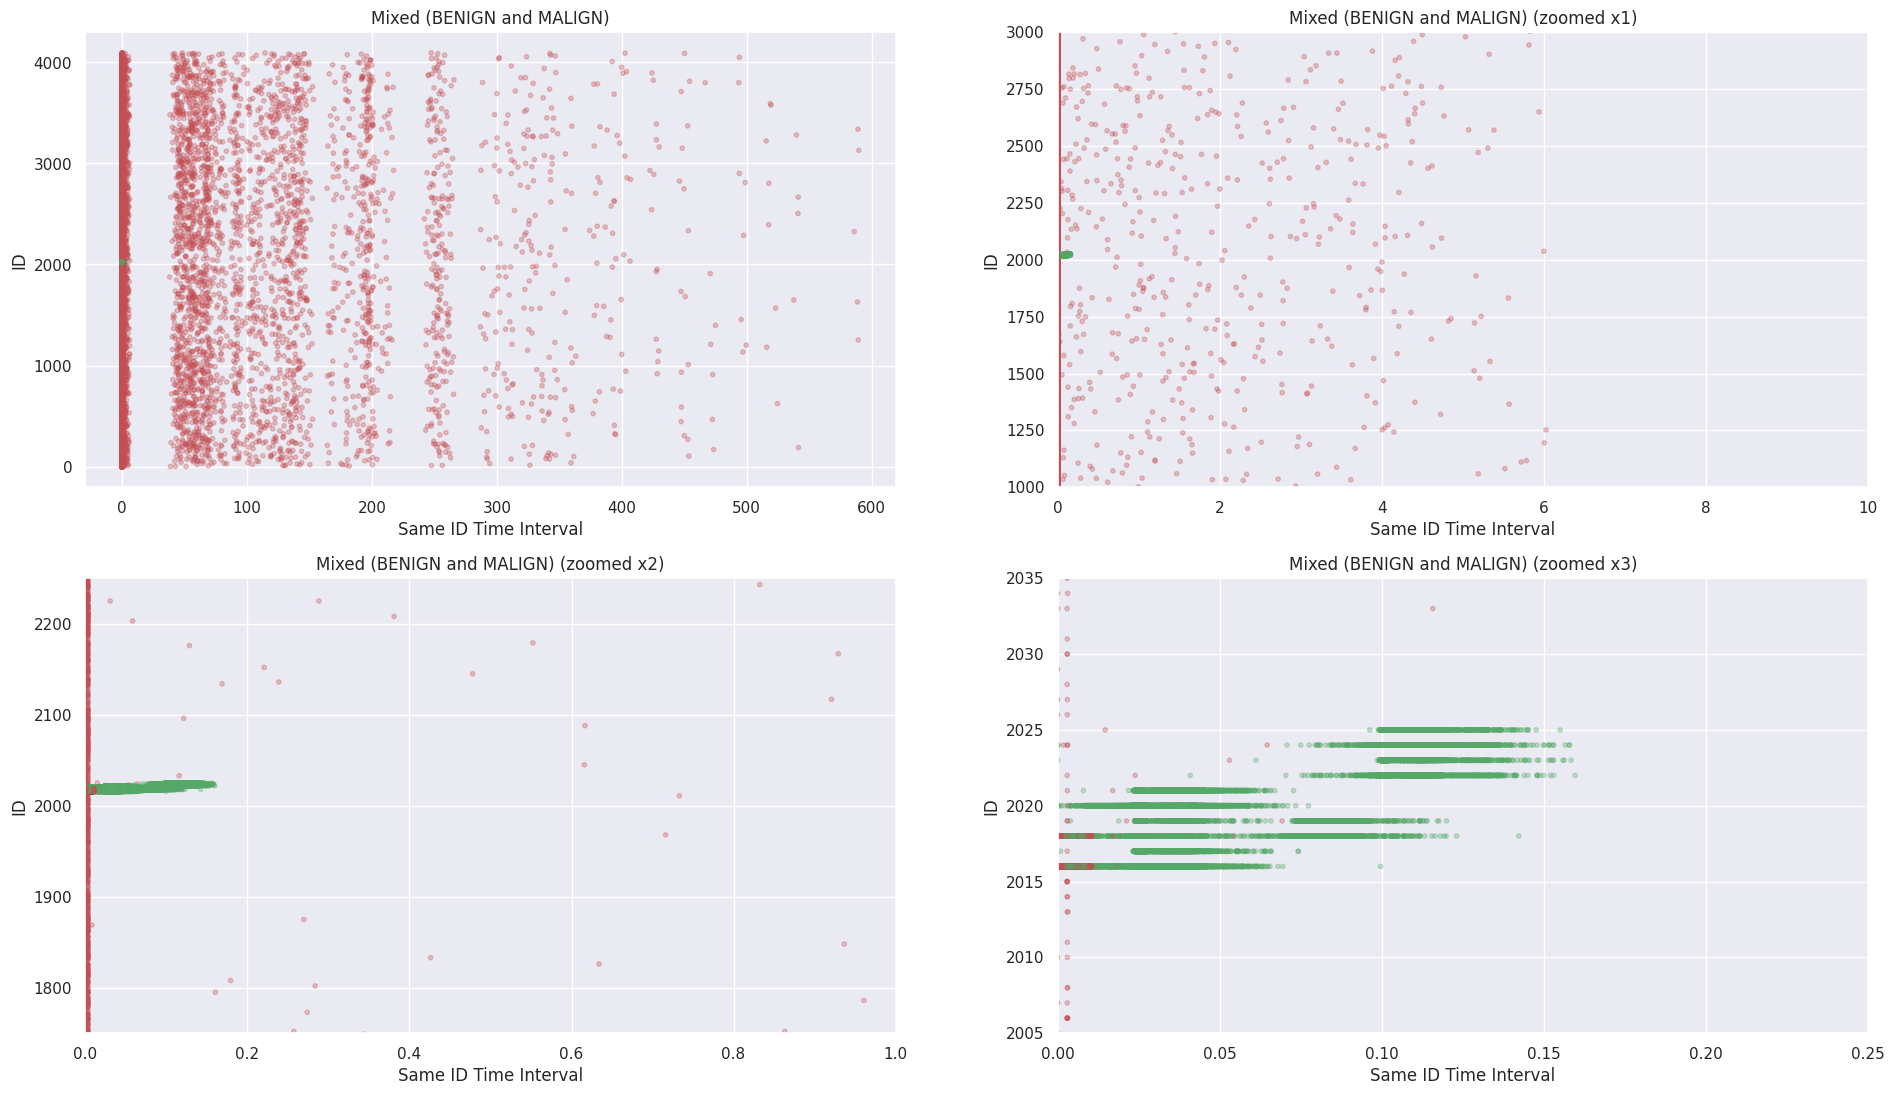

In [ ]:
# @title distribuição de id X same_id_time_interval

%matplotlib inline
fig, ((ax1_0, ax1_1), (ax2_0, ax2_1)) = plt.subplots(2, 2, figsize=(23, 13))

colors = np.where(df.label == 'BENIGN','g','r')
ax1_0.scatter(df['same_id_time_interval'], df['id'], s=10, alpha=0.3, c=colors)
ax1_0.set_title('Mixed (BENIGN and MALIGN)')
ax1_0.set_xlabel('Same ID Time Interval')
ax1_0.set_ylabel('ID')

ax1_1.scatter(df['same_id_time_interval'], df['id'], s=10, alpha=0.3, c=colors)
ax1_1.set_xlim(0, 10)
ax1_1.set_ylim(1000, 3000)
ax1_1.set_title('Mixed (BENIGN and MALIGN) (zoomed x1)')
ax1_1.set_xlabel('Same ID Time Interval')
ax1_1.set_ylabel('ID')

ax2_0.scatter(df['same_id_time_interval'], df['id'], s=10, alpha=0.3, c=colors)
ax2_0.set_xlim(0, 1)
ax2_0.set_ylim(1750, 2250)
ax2_0.set_title('Mixed (BENIGN and MALIGN) (zoomed x2)')
ax2_0.set_xlabel('Same ID Time Interval')
ax2_0.set_ylabel('ID')

ax2_1.scatter(df['same_id_time_interval'], df['id'], s=10, alpha=0.3, c=colors)
ax2_1.set_xlim(0, 0.25)
ax2_1.set_ylim(2005, 2035)
ax2_1.set_title('Mixed (BENIGN and MALIGN) (zoomed x3)')
ax2_1.set_xlabel('Same ID Time Interval')
ax2_1.set_ylabel('ID')

Saving frame 0 of 40
Saving frame 1 of 40
Saving frame 2 of 40
Saving frame 3 of 40
Saving frame 4 of 40
Saving frame 5 of 40
Saving frame 6 of 40
Saving frame 7 of 40
Saving frame 8 of 40
Saving frame 9 of 40
Saving frame 10 of 40
Saving frame 11 of 40
Saving frame 12 of 40
Saving frame 13 of 40
Saving frame 14 of 40
Saving frame 15 of 40
Saving frame 16 of 40
Saving frame 17 of 40
Saving frame 18 of 40
Saving frame 19 of 40
Saving frame 20 of 40
Saving frame 21 of 40
Saving frame 22 of 40
Saving frame 23 of 40
Saving frame 24 of 40
Saving frame 25 of 40
Saving frame 26 of 40
Saving frame 27 of 40
Saving frame 28 of 40
Saving frame 29 of 40
Saving frame 30 of 40
Saving frame 31 of 40
Saving frame 32 of 40
Saving frame 33 of 40
Saving frame 34 of 40
Saving frame 35 of 40
Saving frame 36 of 40
Saving frame 37 of 40
Saving frame 38 of 40
Saving frame 39 of 40


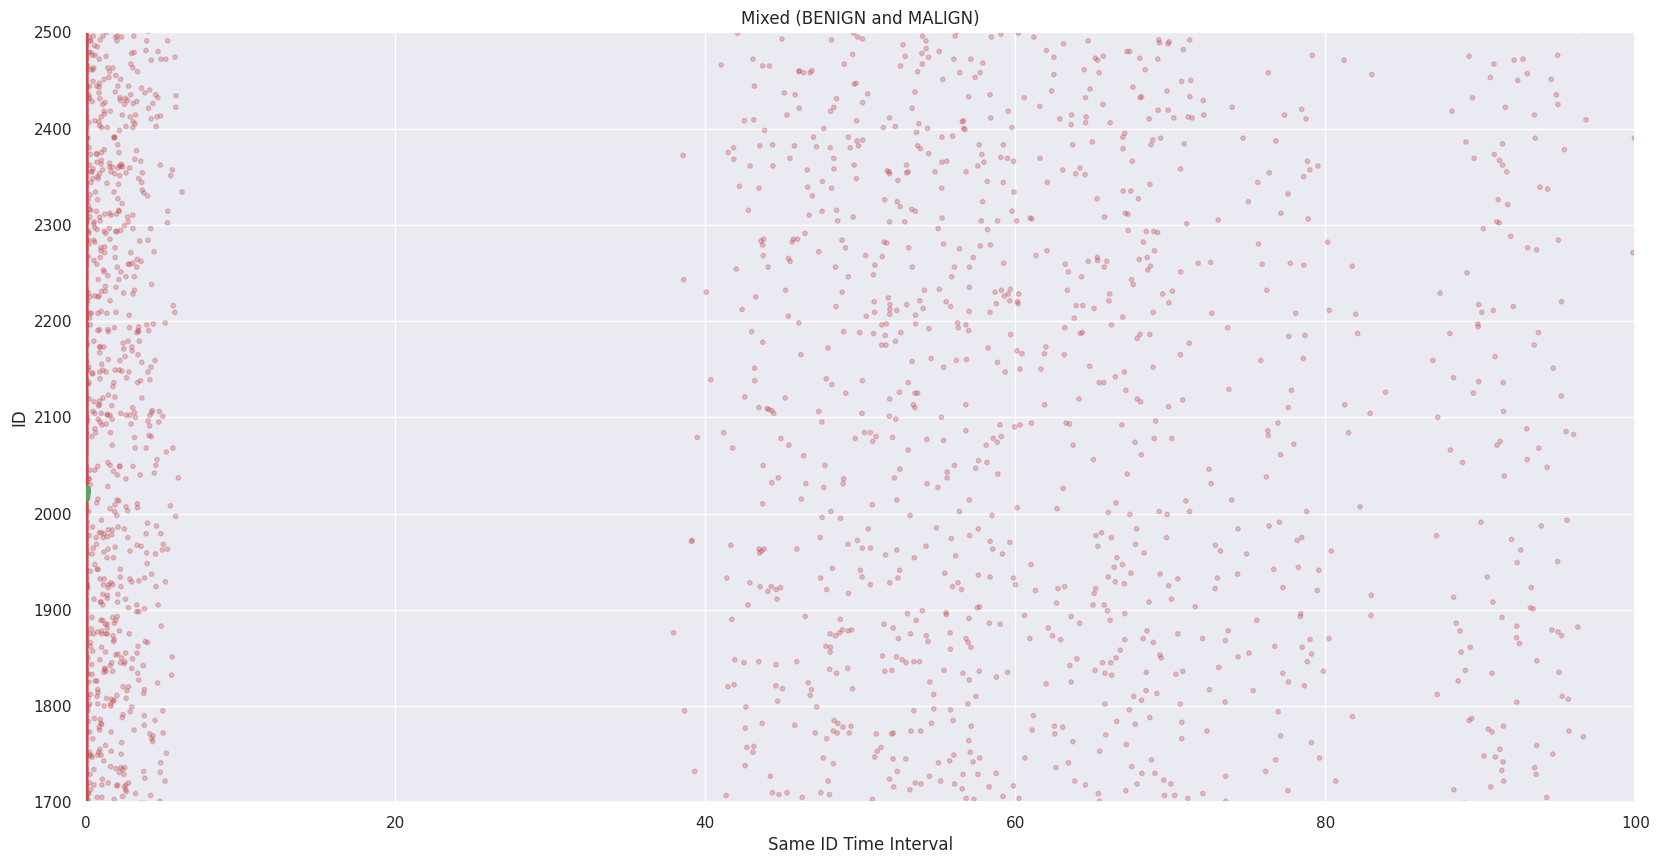

In [ ]:
# @title código para animação

import matplotlib.animation as animation

# Create the figure and the scatter plot
fig = plt.figure(figsize=(20, 10))
colors = np.where(df['label'] == 'BENIGN', 'g', 'r')
scatter = plt.scatter(df['same_id_time_interval'], df['id'], s=10, alpha=0.3, c=colors)
plt.title('Mixed (BENIGN and MALIGN)')
plt.xlabel('Same ID Time Interval')
plt.ylabel('ID')

# Set initial and end limits
initial_xlim = (0, 100)
initial_ylim = (1700, 2500)
end_xlim = (0, 0.2)
end_ylim = (2010, 2030)

# Function to update the zoom in animation
def zoom_in(frame):
    progress = frame / 40
    zoom_factor = 0.01 ** progress
    new_xlim = (initial_xlim[0] * zoom_factor + end_xlim[0] * (1 - zoom_factor),
                initial_xlim[1] * zoom_factor + end_xlim[1] * (1 - zoom_factor))
    new_ylim = (initial_ylim[0] * zoom_factor + end_ylim[0] * (1 - zoom_factor),
                initial_ylim[1] * zoom_factor + end_ylim[1] * (1 - zoom_factor))
    plt.xlim(new_xlim)
    plt.ylim(new_ylim)

# Create the animation
ani = animation.FuncAnimation(fig, zoom_in, frames=40, interval=100)

ani.save('zoom_animation.gif', writer='imagemagick', progress_callback=lambda i, n: print(f'Saving frame {i} of {n}'))

## Data separation

In [ ]:
# train/test separation
df_train = df.query('label == "BENIGN"').sample(frac=0.8, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)
print("df_train.shape: ", df_train.shape, "df_val_test.shape: ", df_val_test.shape)

# Balance the test data
df_val_test_minority  = df_val_test[df_val_test.label=='BENIGN'] # Select benign
df_val_test_majority = df_val_test[df_val_test.label=='MALIGN'] # Select malign
df_val_test_majority = df_val_test_majority.sample(len(df_val_test_minority), random_state=0) # Sample malign using benign count
df_val_test = pd.concat([df_val_test_majority,df_val_test_minority])
df_val_test = df_val_test.sample(frac=1, random_state=0) # Shuffle the dataset to prevent the model from getting biased
print("df_val_test (após balanceamento): ", df_val_test.shape)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

Y_train = df_train.label.apply(lambda c: 0 if c == 'BENIGN' else 1)
X_train = df_train.drop('label', axis='columns')

df_train.shape:  (5480, 12) df_val_test.shape:  (27735, 12)
1370 26365 27735
df_val_test (após balanceamento):  (2740, 12)


In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('label', axis='columns'), df_val_test['label'], test_size=0.9, stratify=df_val_test['label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
# Padronizar os dados
scaler = StandardScaler()
scaler.fit(original_df[original_df.label == "BENIGN"].drop(columns="label"))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print(X_test_scaled.shape, X_train_scaled.shape)

(2546, 11) (5656, 11)


# Train and evaluate model



In [ ]:
# @title Hyperparameter tuning (optional)
# Define the parameter grid
param_grid = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'nu': [0.1, 0.25, 0.5, 0.75]
}

# Initialize the model
model = OneClassSVM()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='accuracy')
grid_search.fit(X_train_scaled, Y_train.replace([-1,1],[1,0]))

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Model:", best_model)

Best Parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}
Best Model: OneClassSVM(nu=0.1)


In [ ]:
# Treinar o modelo OCSVM
model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1) # Valores após tuning
model.fit(X_train_scaled)

OneClassSVM(nu=0.1)

In [ ]:
# Prever com o modelo treinado
y_pred = model.predict(X_test_scaled)
svm_pred = pd.Series(y_pred).replace([-1,1],[1,0]) # O SVM retorna -1 como anomalias

In [ ]:
# @title confusion matrix code
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

Accuracy: 0.9524744697564808
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1273
           1       0.91      1.00      0.95      1273

    accuracy                           0.95      2546
   macro avg       0.96      0.95      0.95      2546
weighted avg       0.96      0.95      0.95      2546



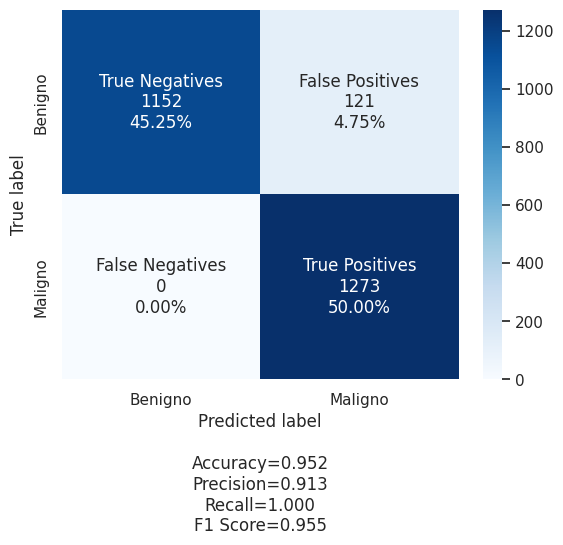

In [ ]:
# Avaliar o modelo
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("Classification Report:")
print(classification_report(y_test, svm_pred))

cf_matrix = confusion_matrix(y_test, svm_pred)
labels = ["True Negatives","False Positives","False Negatives","True Positives"]
categories = ["Benigno", "Maligno"]
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories)

# Análise dos falsos positivos

In [ ]:
df_confusion_analysis = X_test
df_confusion_analysis['y_test'] = y_test
df_confusion_analysis['svm_pred'] = svm_pred

# Function to classify entries
def classify(row):
    if row['y_test'] == 1 and row['svm_pred'] == 1:
        return 'TP'  # True Positive
    elif row['y_test'] == 0 and row['svm_pred'] == 0:
        return 'TN'  # True Negative
    elif row['y_test'] == 0 and row['svm_pred'] == 1:
        return 'FP'  # False Positive
    elif row['y_test'] == 1 and row['svm_pred'] == 0:
        return 'FN'  # False Negative

# Apply the classification function
df_confusion_analysis['classification'] = df_confusion_analysis.apply(classify, axis=1)

# Filter DataFrame for each classification
false_positives = df_confusion_analysis[df_confusion_analysis['classification'] == 'FP']
false_negatives = df_confusion_analysis[df_confusion_analysis['classification'] == 'FN']
true_positives = df_confusion_analysis[df_confusion_analysis['classification'] == 'TP']
true_negatives = df_confusion_analysis[df_confusion_analysis['classification'] == 'TN']

false_positives

,id,byte0,byte1,byte2,byte3,byte4,byte5,byte6,byte7,time_interval,same_id_time_interval,y_test,svm_pred,classification
18,2022,0,65,245,0,-1,-1,-1,-1,0.000914,0.135937,0,1,FP
26,2020,0,65,246,0,-1,-1,-1,-1,0.000175,0.012708,0,1,FP
30,2024,0,65,244,128,0,-1,-1,-1,0.000191,0.127928,0,1,FP
46,2021,2,1,246,85,85,85,85,85,0.000234,0.024520,0,1,FP
64,2017,2,1,73,85,85,85,85,85,0.000224,0.024396,0,1,FP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2352,2025,2,1,244,85,85,85,85,85,0.000231,0.110015,0,1,FP
2367,2025,2,1,244,85,85,85,85,85,0.015184,0.114065,0,1,FP
2412,2025,2,1,244,85,85,85,85,85,0.000275,0.132769,0,1,FP
2416,2019,2,1,13,85,85,85,85,85,0.019889,0.024787,0,1,FP


# Export model and scaler

In [ ]:
from pickle import dump
with open("ocsvm-ids-scaler.pkl", "wb") as f:
    dump([model, scaler], f, protocol=5)